In [0]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import torch.nn as nn
import torch.optim as optim

## Dataloading

In [2]:
import torchvision
import torchvision.transforms as transforms
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform=transforms.ToTensor())

0it [00:00, ?it/s]

170500096it [00:09, 18432781.09it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data


In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[0].shape)
print(labels[0].item())

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])
6


## Visualize data

In [6]:
img = images[0]
print(type(img))

<class 'torch.Tensor'>


In [7]:
npimg = img.numpy()
print(npimg.shape)

(3, 32, 32)


In [8]:
npimg = np.transpose(npimg, (1, 2, 0))
print(npimg.shape)

(32, 32, 3)


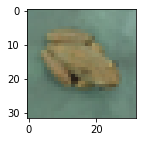

In [9]:
plt.figure(figsize=(2,2))
plt.imshow(npimg)
plt.show()

In [0]:
def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

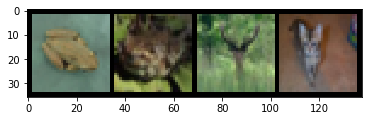

frog frog deer cat


In [11]:
plt.figure(figsize=(6,6))
imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[labels[j]] for j in range(4)))

## Single Convolution Layer

In [0]:
class FirstCNN(nn.Module):

  def __init__(self):
    super(FirstCNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 3) # default no padding,  padding=(1,1), stride=(2,2)
  
  def forward(self, x):
    x = self.conv1(x)
    return x

In [0]:
net = FirstCNN()

In [0]:
out = net(images)
out.shape

torch.Size([4, 16, 30, 30])

In [0]:
for param in net.parameters():
  print(param.shape) # weights and biases

torch.Size([16, 3, 3, 3])
torch.Size([16])


In [0]:
out1 = out[0,0,:,:].detach().numpy()
out1.shape

(30, 30)

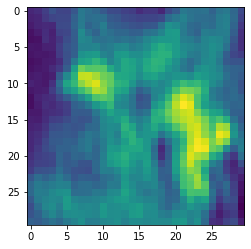

In [0]:
plt.imshow(out1)
plt.show()

## Deep Convolutional Layer

In [0]:
class FirstCNN_v2(nn.Module):

  def __init__(self):
    super(FirstCNN_v2, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 8, 3), # (N, 3, 32, 32) -> (N, 8, 30, 30)
        nn.Conv2d(8, 16, 3) # (N, 8, 30, 30) -> (N, 16, 28, 28)
    )
  
  def forward(self, x):
    x = self.net(x)
    return x

In [0]:
net = FirstCNN_v2()
out = net(images)
out.shape

torch.Size([4, 16, 28, 28])

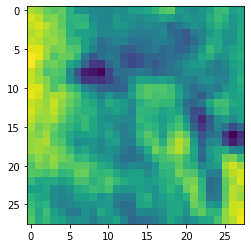

In [0]:
plt.imshow(out[0,0,:,:].detach().numpy())
plt.show()

In [0]:
class FirstCNN_v3(nn.Module):

  def __init__(self):
    super(FirstCNN_v3, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 6, 5), # (N, 3, 32, 32) -> (N, 6, 28, 28)
        nn.AvgPool2d(2, stride=2), # (N, 6, 28, 28) -> (N, 6, 14, 14)
        nn.Conv2d(6, 16, 5), # (N, 6, 14, 14) -> (N, 16, 10, 10)
        nn.AvgPool2d(2, stride=2) # (N, 16, 10, 10) -> (N, 16, 5, 5)
    )
  
  def forward(self, x):
    x = self.net(x)
    return x

In [0]:
net = FirstCNN_v3()
out = net(images)
out.shape

torch.Size([4, 16, 5, 5])

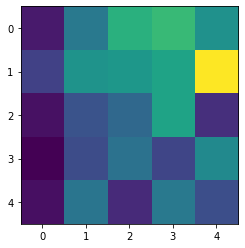

In [0]:
plt.imshow(out[0,0,:,:].detach().numpy())

## LeNet

In [0]:
class LeNet(nn.Module):

  def __init__(self):
    super(LeNet, self).__init__()
    self.cnn_model = nn.Sequential(
        nn.Conv2d(3, 6, 5),  # (N, 3, 32, 32) -> (N, 6, 28, 28)
        nn.ReLU(),
        # nn.Tanh(),
        nn.AvgPool2d(2, stride=2), # (N, 6, 28, 28) -> (N, 6, 14, 14)
        nn.Conv2d(6, 16, 5), # (N, 6, 14, 14) -> (N, 16, 10, 10)
        nn.ReLU(),
        # nn.Tanh(),
        nn.AvgPool2d(2, stride=2) # (N, 16, 10, 10) -> (N, 16, 5, 5)
    )
    self.fc_model = nn.Sequential(
        nn.Linear(400, 120),
        nn.Dropout(0.4),
        nn.ReLU(),
        # nn.Tanh(),
        nn.Linear(120, 84),
        nn.Dropout(0.4),
        nn.ReLU(),
        # nn.Tanh(),
        nn.Linear(84, 10)
    )

  def forward(self, x):
    x = self.cnn_model(x)
    # print(x.shape)
    x = x.view(x.size(0), -1)
    # print(x.shape)
    x = self.fc_model(x)
    # print(x.shape)
    return x

In [13]:
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### CPU implementation

In [0]:
def evaluation(dataloader):
  total, correct = 0, 0
  for data in dataloader:
    images, labels = data
    output = lenet(images)
    total += labels.size(0)
    _, pred = torch.max(output.data, axis=1)
    correct += (pred==labels).sum().item()
  return 100 * correct/total

In [0]:
lenet = LeNet()

In [0]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(lenet.parameters())

Epoch (0/16): Test acc: 38.29, Train acc: 38.05
Epoch (1/16): Test acc: 43.67, Train acc: 44.33
Epoch (2/16): Test acc: 47.21, Train acc: 47.76
Epoch (3/16): Test acc: 50.59, Train acc: 51.67
Epoch (4/16): Test acc: 51.94, Train acc: 54.47
Epoch (5/16): Test acc: 52.90, Train acc: 55.51
Epoch (6/16): Test acc: 53.91, Train acc: 57.41
Epoch (7/16): Test acc: 54.77, Train acc: 59.06
Epoch (8/16): Test acc: 54.47, Train acc: 59.73
Epoch (9/16): Test acc: 55.04, Train acc: 60.66
Epoch (10/16): Test acc: 55.15, Train acc: 61.96
Epoch (11/16): Test acc: 55.32, Train acc: 62.23
Epoch (12/16): Test acc: 55.62, Train acc: 63.90
Epoch (13/16): Test acc: 56.06, Train acc: 65.23
Epoch (14/16): Test acc: 55.74, Train acc: 64.92
Epoch (15/16): Test acc: 56.25, Train acc: 66.07


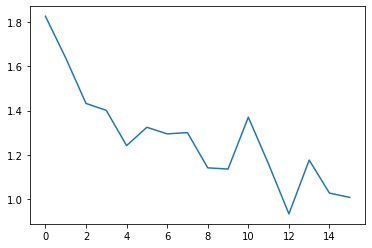

CPU times: user 8min 4s, sys: 6.69 s, total: 8min 11s
Wall time: 8min 12s


In [0]:
%%time

loss_arr = []
loss_epoch_arr = []
max_epochs = 16

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader):

    images, labels = data

    opt.zero_grad()

    outputs = lenet(images)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    loss_arr.append(loss.item())

  loss_epoch_arr.append(loss.item())

  print('Epoch (%d/%d): Test acc: %.2f, Train acc: %.2f' % (epoch, max_epochs, evaluation(testloader), evaluation(trainloader)))

plt.plot(loss_epoch_arr)
plt.show()

### Move to GPU

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
def evaluation(dataloader):
  total, correct = 0, 0
  for data in dataloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    output = lenet(images)
    total += labels.size(0)
    _, pred = torch.max(output.data, axis=1)
    correct += (pred==labels).sum().item()
  return 100 * correct/total

In [0]:
lenet = LeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(lenet.parameters(), lr=0.0001, weight_decay=0.0001)

Epoch (1/25): Test acc: 56.27, Train acc: 60.76
Epoch (2/25): Test acc: 55.84, Train acc: 60.21
Epoch (3/25): Test acc: 56.39, Train acc: 60.45
Epoch (4/25): Test acc: 56.87, Train acc: 60.97
Epoch (5/25): Test acc: 56.30, Train acc: 59.82
Epoch (6/25): Test acc: 57.58, Train acc: 61.15
Epoch (7/25): Test acc: 57.07, Train acc: 61.61
Epoch (8/25): Test acc: 57.66, Train acc: 61.93
Epoch (9/25): Test acc: 56.82, Train acc: 61.78
Epoch (10/25): Test acc: 56.83, Train acc: 61.15
Epoch (11/25): Test acc: 57.26, Train acc: 62.24
Epoch (12/25): Test acc: 56.86, Train acc: 62.03
Epoch (13/25): Test acc: 57.78, Train acc: 62.47
Epoch (14/25): Test acc: 57.35, Train acc: 62.23
Epoch (15/25): Test acc: 57.40, Train acc: 61.82
Epoch (16/25): Test acc: 57.89, Train acc: 62.61
Epoch (17/25): Test acc: 58.02, Train acc: 62.71
Epoch (18/25): Test acc: 57.11, Train acc: 61.74
Epoch (19/25): Test acc: 58.27, Train acc: 61.92
Epoch (20/25): Test acc: 58.37, Train acc: 63.08
Epoch (21/25): Test acc: 58.4

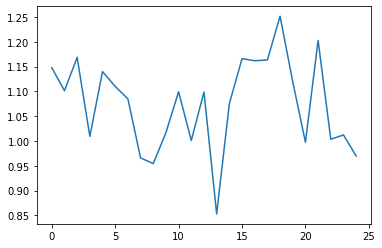

CPU times: user 7min 10s, sys: 2.07 s, total: 7min 13s
Wall time: 7min 14s


In [0]:
%%time

loss_arr = []
loss_epoch_arr = []
max_epochs = 25

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader):

    images, labels = data
    images, labels = images.to(device), labels.to(device)

    opt.zero_grad()

    outputs = lenet(images)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    loss_arr.append(loss.item())

  loss_epoch_arr.append(loss.item())

  print('Epoch (%d/%d): Test acc: %.2f, Train acc: %.2f' % (epoch, max_epochs, evaluation(testloader), evaluation(trainloader)))

plt.plot(loss_epoch_arr)
plt.show()

## Basic Visualization

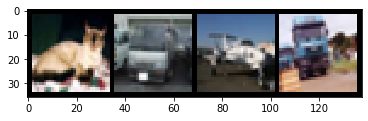

In [0]:
imshow(torchvision.utils.make_grid(images))

In [0]:
lenet = lenet.to('cpu')

In [0]:
out = lenet(images)

In [0]:
out = lenet.cnn_model[0](images)
out.shape

torch.Size([4, 6, 28, 28])

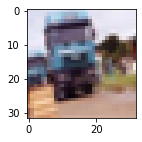

In [0]:
image_id = 3
plt.figure(figsize=(2, 2))
imshow(images[image_id])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


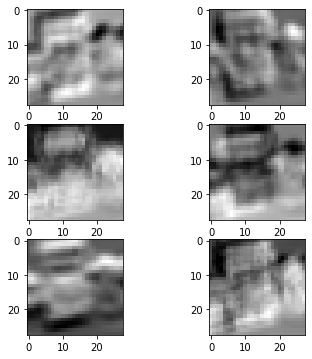

In [0]:
plt.figure(figsize=(6, 6))
plt.subplot(321)
for i in range(6):
  ax1 = plt.subplot(3, 2, i+1)
  plt.imshow(out[image_id, i, :, :].detach().numpy(), cmap='binary')
plt.show()

## Exercises

1. Modify LeNet with Relu instead of Tanh
2. solve over-fitting by adding L2 regularization with adam
3. Use Mnist data instead of CIFAR
4. Tune LeNet to get optimized test accuracy